In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 5.1 - Introduction to convnets

This notebook contains the code sample found in Chapter 5, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

First, let's take a practical look at a very simple convnet example. We will use our convnet to classify MNIST digits, a task that you've already been 
through in Chapter 2, using a densely-connected network (our test accuracy then was 97.8%). Even though our convnet will be very basic, its 
accuracy will still blow out of the water that of the densely-connected model from Chapter 2.

The 6 lines of code below show you what a basic convnet looks like. It's a stack of `Conv2D` and `MaxPooling2D` layers. We'll see in a 
minute what they do concretely.
Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)` (not including the batch dimension). 
In our case, we will configure our convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this via 
passing the argument `input_shape=(28, 28, 1)` to our first layer.

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Instructions for updating:
Colocations handled automatically by placer.


Let's display the architecture of our convnet so far:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width 
and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to 
the `Conv2D` layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape `(3, 3, 64)`) into a densely-connected classifier network like those you are 
already familiar with: a stack of `Dense` layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. 
So first, we will have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top:

In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network 
looks like:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

Now, let's train our convnet on the MNIST digits. We will reuse a lot of the code we have already covered in the MNIST example from Chapter 
2.

In [0]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1893 - acc: 0.9415
Epoch 2/5
60000/60000 [==============================] - 64s 1ms/step - loss: 0.0588 - acc: 0.9828
Epoch 3/5
60000/60000 [==============================] - 64s 1ms/step - loss: 0.0447 - acc: 0.9872
Epoch 4/5
60000/60000 [==============================] - 64s 1ms/step - loss: 0.0325 - acc: 0.9904
Epoch 5/5
60000/60000 [==============================] - 64s 1ms/step - loss: 0.0255 - acc: 0.9920


Let's evaluate the model on the test data:

In [0]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 4s 374us/step


In [0]:
test_acc

0.9897

While our densely-connected network from Chapter 2 had a test accuracy of 97.8%, our basic convnet has a test accuracy of 99.3%: we 
decreased our error rate by 68% (relative). Not bad! 

___But why does this simple convnet work so well, compared to a densely connected
model?___

___To answer this, let’s dive into what the Conv2D and MaxPooling2D layers do.___

# The convolution operation

## Why?
__Dense is global while Conv is local__
![5.1_1_local_conv.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_1_local_conv.png?raw=true)

___Key conv properties___:
- The patterns they learn are ___translation invariant___

After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it ___anywhere___: 

for example, in the upper-left corner. A densely connected network would have to learn the pattern anew if it appeared at a new location. 

This makes convnets ___data efficient___ when processing images (because the visual world is fundamentally translation invariant): 

they need _fewer training samples_ to learn representations that have generalization power.



- They can learn ___spatial hierarchies___ of patterns
the visual world is fundamentally spatially hierarchical
![5.1_2_hier_cat_example.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_2_hier_cat_example.png?raw=true)


# Basics of convolution from Signal Processing

__Output = Response --> Obtained by convolution__
![5.1_3_filter.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_3_filter.png?raw=true)

# Conv Filters perform template matching = Search for a pattern

__1D__
![5.1_4_1D_pattern_search.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_4_1D_pattern_search.png?raw=true)

__2D__

![5.1_5_2D_pattern_search.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_5_2D_pattern_search.png?raw=true)

![5.1_6_2D_correlation_map.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_6_2D_correlation_map.png?raw=true)

# Terminology

- Feature = Kernel = Filter = template --> parametrized by fitler coefficients. 
- Feature Extraction = matching = conv operation
- Feature map = result of conv = filter response


Example of features are edge detectors
A Kernel is a feature detector – Local features
![5.1_7_edge_detection.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_7_edge_detection.png?raw=true)

# Convolution and Deep Learning
__Instead of designing the filter coefficients, lets learn them!__

_Now filter coeff. = weights_

Convolutions operate over 3D tensors, called __feature maps__, with two spatial axes (_height_ and _width_) as well as a _depth_ axis (also called the ___channels axis___). 

For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. 

For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray). 




The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an ___output feature map___. 

__Filter vs. Feature map__

This __output feature map is still a 3D tensor__: it has a width and a height. 

___Its depth can be arbitrary___, because the output depth is a _parameter of the layer_, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for __filters__. 

_Feature map = 3D tensor_

_Filter = 2D kernel ==> each channel feature map = response map_

Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,”for instance. 



In the MNIST example, the first convolution layer takes a feature map of size (28, 28, 1) and outputs a feature map of size (26, 26, 32): it computes 32 filters over its input. Each of these 32 output channels contains a 26 × 26 grid of values, which is a response map of the filter over the input, indicating the response of that filter pattern at different locations in the input. 

___That is what the term feature map means___: every dimension in the depth axis is a feature (or filter), and the 2D tensor output[:, :, n] is the 2D spatial map of the response of this filter over the input.

![5.1_8_response_map.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_8_response_map.png?raw=true)

# Convolutions are defined by two key parameters:

- ___Kernel size___ Size of the patches extracted from the inputs—These are typically 3 × 3 or 5 × 5. In the
example, they were 3 × 3, which is a common choice.
-  ___Output channels___ Depth of the output feature map—The number of filters computed by the convolution.
The example started with a depth of 32 and ended with a depth of 64.

# How convolution occurs
- We have n_in_channels x L x W x n_out_channels kernel tensors as follows:
    - For each input channel, we have LxW kernel --> in_channel_block
    - We have n_out_channel of these in_channel_block
    - We perform a do prodcut of each in_channel_block with the input tensor feature map, which gives us out_feature_map for each output channel. Note that, the dot product sums over the in_channels, so this dimension disappear.
    - We have an output = n_out_channels x L_out x W_out. L_out and W_out are determined according to the border effect and stride (see below).

![5.1_9_conv_example.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_9_conv_example.png?raw=true)

__Note that the output width and height may differ from the input width and height.__

They may differ for two reasons:
- __Border effects__, which can be countered by padding the input feature map
- The use of __strides__, which I’ll define in a second
Let’s take a deeper look at these notions.

# UNDERSTANDING BORDER EFFECTS AND PADDING
Consider a 5 × 5 feature map (25 tiles total). There are only 9 tiles around which you
can center a 3 × 3 window, forming a 3 × 3 grid. Hence, the output feature
map will be 3 × 3. It shrinks a little: by exactly two tiles alongside each dimension,
in this case. You can see this border effect in action in the earlier example: you start
with 28 × 28 inputs, which become 26 × 26 after the first convolution layer.



__VALID conv__
- Kernel = MxM
- Input = NxN
- Output = N-M+1 x N-M+1

PAD = No padding

![5.1_10_border_effect.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_10_border_effect.png?raw=true)

If you want to get an output feature map with the same spatial dimensions as the input, you can use padding. Padding consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center
convolution windows around every input tile. 

For a 3 × 3 window, you add one column on the right, one column on the left, one row at the top, and one row at the
bottom. For a 5 × 5 window, you add two rows:

Padding is (M-1)/2 in general.

__SAME conv__
- Kernel = MxM
- Input = NxN
- Output = NxN 

PAD = (M-1)/2, so out=(N + 2 * (M-1)/2) - M + 1 = M

![5.1_11_SAME_conv_pad.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_11_SAME_conv_pad.png?raw=true)

In Conv2D layers, padding is configurable via the padding argument, which takes two
values: "valid", which means no padding (only valid window locations will be used);
and "same", which means “pad in such a way as to have an output with the same width
and height as the input.” The padding argument defaults to "valid".

Note that, the normal convolution produces bigger size, but this is not in Keras.

In this type (default from signal processing), we pad with the size of the kernel (M) on each side.

__NORM conv__
- Kernel = MxM
- Input = NxN
- Output = N+M-1xN+M-1

PAD = M, so out = (N+2*M) - M + 1 = N + M - 1 

___UNDERSTANDING CONVOLUTION STRIDES___

The other factor that can influence output size is the notion of strides. 

The description of convolution so far has assumed that the center tiles of the convolution windows are all contiguous. 

But the __distance between two successive windows__ is a parameter of the convolution, called its stride, which defaults to 1. 

It’s possible to have strided convolutions: convolutions with a stride higher than 1. 

You can see the patches extracted by a 3 × 3 convolution with stride 2 over a 5 × 5 input (without padding).

![5.1_12_stride.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/5.1_12_stride.png?raw=true)

__Padding equations for 3 conv types in case of stride S__

VALID --> PAD = 0, Out--> (N-M+1)/S

SAME --> Invalid in case of strides. Meaning, you cannot get SAME output size as input in case of stride.

NORM--> Output size = [ (N-M+2P)/S ]  + 1, with S and P such that the PAD is integer. 2P because we pad right and left. stride is the same before and after (same step in all directions).

Check the above equation with S = 1, P = (M-1)/2, you get output size = N



## Downsample feature maps, why? 
Why not remove the max-pooling layers and keep fairly large feature maps all the way up? Let’s look at this option. The convolutional base of the model would then look like this:

In [0]:
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [0]:
model_no_max_pool.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


# What’s wrong with this setup? Two things:

- It isn’t ___conducive to learning a spatial hierarchy of features___. 
The 3 × 3 windows in the third layer will only contain information coming from 7 × 7 windows in
the initial input. The high-level patterns learned by the convnet will still be very small with regard to the initial input, which may not be enough to learn to classify digits (try recognizing a digit by only looking at it through windows that are
7 × 7 pixels!). 

_We need the features from the last convolution layer to contain information about the totality of the input._

- The final feature map has 22 × 22 × 64 = 30,976 total coefficients per sample.
___This is huge___. If you were to flatten it to stick a Dense layer of size 512 on top,
that layer would have 15.8 million parameters. 

_This is far too large for such a small model and would result in intense overfitting._

In short, the reason to use __downsampling__ is to ___reduce the number of feature-map
coefficients to process__, as well as to ___induce spatial-filter hierarchies by making successive
convolution layers look at increasingly large windows__ (in terms of the fraction of
the original input they cover).

Note that max pooling isn’t the only way you can achieve such downsampling. 
As you already know, you can also use strides in the prior convolution layer. 

And you can use __average pooling__ instead of max pooling, where each local input patch is transformed by taking the average value of each channel over the patch, rather than the max. 
But max pooling tends to work better than these alternative solutions. 

In a nutshell, the reason is that features tend to encode the spatial presence of some pattern or concept over the different tiles of the feature map (hence, the term feature map), and __it’s more informative to look at the maximal presence of different features than at their average presence__. 

So the most reasonable subsampling strategy is to first produce dense maps of features (via unstrided convolutions) and then look at the maximal activation of the features over small patches, rather than looking at sparser windows of
the inputs (via strided convolutions) or averaging input patches, which could cause you to miss or dilute feature-presence information.


# Why strides?
___Downsampling___

__Stride 2 conv:
Using stride 2 means the width and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects).
So in SAME conv (the most widely used type, we halve the size by stride 2 conv__

According to the equations (valid: (N-M+1)/S, normal: (N-M+2P)/S + 1) stride 2 conv gives roughtly half the size:

![strid_2](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_strides.gif)


_Strided convolutions are rarely used in practice_, although they can come in handy for some types of models; it’s good to be familiar with the concept.

To downsample feature maps, instead of strides, we tend to use the __max-pooling__ operation, which you saw in action in the first convnet example. Let’s look at it in more depth.

# The pooling operation

_Downsampling_: In the convnet example, you may have noticed that the size of the feature maps is halved after every MaxPooling2D layer. 

For instance, before the first MaxPooling2D layers, the feature map is 26 × 26, but the max-pooling operation halves it to 13 × 13.

_That’s the role of max pooling: to aggressively downsample feature maps, much like strided convolutions._

Max pooling consists of extracting windows from the input feature maps and outputting the max value of each channel.

_It’s conceptually similar to convolution, except that instead of transforming local patches via a learned linear transformation (the convolution kernel), they’re transformed via a hardcoded max tensor operation._

_A big difference from convolution is that max pooling is usually done with 2 × 2 windows and stride 2, in order to downsample the feature maps by a factor of 2. On the other hand, convolution is typically done with 3 × 3 windows and no stride (stride 1)._

__Average Pooling__

https://medium.com/@bdhuma/which-pooling-method-is-better-maxpooling-vs-minpooling-vs-average-pooling-95fb03f45a9


Max pooling selects the brighter pixels from the image. It is useful when the background of the image is dark and we are interested in only the lighter pixels of the image. For example: in MNIST dataset, the digits are represented in white color and the background is black. So, max pooling is used. Similarly, min pooling is used in the other way round. 

Whereas average pooling extracts features like edges so smoothly.


--2019-08-06 10:22:20--  https://www.w3schools.com/w3css/img_lights.jpg
Resolving www.w3schools.com (www.w3schools.com)... 192.229.173.207
Connecting to www.w3schools.com (www.w3schools.com)|192.229.173.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20461 (20K) [image/jpeg]
Saving to: ‘img_lights.jpg’

img_lights.jpg      100%[===================>]  19.98K  --.-KB/s    in 0s      

2019-08-06 10:22:25 (205 MB/s) - ‘img_lights.jpg’ saved [20461/20461]



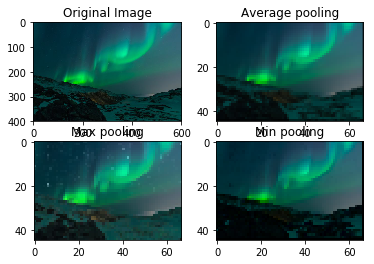

In [1]:

from skimage.measure import block_reduce
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
!wget https://www.w3schools.com/w3css/img_lights.jpg
img = imread('img_lights.jpg')
mean_pool=block_reduce(img, block_size=(9,9,1), func=np.mean)
max_pool=block_reduce(img, block_size=(9,9,1), func=np.max)
min_pool=block_reduce(img, block_size=(9,9,1), func=np.min)

plt.figure(1)
plt.subplot(221)
imgplot = plt.imshow(img.astype(np.uint8))
plt.title('Original Image')

plt.subplot(222)
imgplot3 = plt.imshow(mean_pool.astype(np.uint8))
plt.title('Average pooling')

plt.subplot(223)
imgplot1 = plt.imshow(max_pool.astype(np.uint8))
plt.title('Max pooling')

plt.subplot(224)
imgplot1 = plt.imshow(min_pool.astype(np.uint8))
plt.title('Min pooling')

plt.show()


__Global Average Pooling (GAP)__
Paper: https://arxiv.org/pdf/1312.4400.pdf

In the last few years, experts have turned to global average pooling (GAP) layers to minimize overfitting by reducing the total number of parameters in the model. Similar to max pooling layers, GAP layers are used to reduce the spatial dimensions of a three-dimensional tensor. However, GAP layers perform a more extreme type of dimensionality reduction, where a tensor with dimensions h×w×d is reduced in size to have dimensions 1×1×d. GAP layers reduce each h×w feature map to a single number by simply taking the average of all hw values.

![GAP](https://alexisbcook.github.io/assets/global_average_pooling.png)


https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/

The convolutional neural network starts with a series of convolutional (and, potentially, pooling) layers which create feature maps which represent different components of the input images. The fully connected layers at the end then “interpret” the output of these features maps and make category predictions. However, as with many things in the fast moving world of deep learning research, this practice is starting to fall by the wayside in favor of something called Global Average Pooling (GAP). 

![GAP_not_Dense](https://i2.wp.com/adventuresinmachinelearning.com/wp-content/uploads/2019/05/Global-Average-Pooling-full-network.png?resize=1130%2C317&ssl=1)

The GAP layer transforms the dimensions from (7, 7, 64) to (1, 1, 64) by performing the averaging across the 7 x 7 channel values. Global Average Pooling has the following advantages over the fully connected final layers paradigm:

- The removal of a large number of trainable parameters from the model. Fully connected or dense layers have lots of parameters. A 7 x 7 x 64 CNN output being flattened and fed into a 500 node dense layer yields 1.56 million weights which need to be trained. Removing these layers speeds up the training of your model.
- The elimination of all these trainable parameters also reduces the tendency of over-fitting, which needs to be managed in fully connected layers by the use of dropout.
- The authors argue in the original paper that removing the fully connected classification layers forces the feature maps to be more closely related to the classification categories – so that each feature map becomes a kind of “category confidence map”.
- Finally, the authors also argue that, due to the averaging operation over the feature maps, this makes the model more robust to spatial translations in the data. In other words, as long as the requisite feature is included / or activated in the feature map somewhere, it will still be “picked up” by the averaging operation.






# Special Convolutions:

__1x1 Conv__

1x1 conv is a special operation that helps in reducing the number of feature maps, i.e. the depth of the feature maps.
The 1x1 conv works as a per feature map weighted average to produce bigger or small number of input features maps as you want. A 1x1xout_maps shall produce the same input size (LxW) of the input feature maps, but with the required out_maps number, where every input feature map is multiplied by a weight, and the result is the weighted sum of all the input maps, and every out_map has such weights (cube).
https://machinelearningmastery.com/introduction-to-1x1-convolutions-to-reduce-the-complexity-of-convolutional-neural-networks/

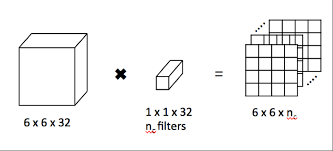

## Deconvolution, Transposed Conv and Upsampling




https://distill.pub/2016/deconv-checkerboard/

When we have neural networks generate images, we often have them build them up from low resolution, high-level descriptions. This allows the network to describe the rough image and then fill in the details.

In order to do this, we need some way to go from a lower resolution image to a higher one. We generally do this with the deconvolution operation. Roughly, deconvolution layers allow the model to use every point in the small image to “paint” a square in the larger one.

(Deconvolution has a number of interpretations and different names, including “transposed convolution.”


http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
https://github.com/vdumoulin/conv_arithmetic

__How to get larger feature maps out of small ones?__
Let’s now consider what would be required to go the other way around, i.e., map from a 4-dimensional space to a 16-dimensional space. This operation is known as a transposed convolution.
Sometimes, it is referred to as "fractionally strided convolutions", becasue if you imagine you have stride S=1/2, then you enlarge the size by 2.

The simplest way is to apply a kernel that is larger in size than the input, and use __normal__ conv:

Convolving kernel N=3 with input M=2 gives N+M-1=4 --> 4x4 output

![Deconv](http://deeplearning.net/software/theano/_images/no_padding_no_strides.gif)

But what if we have a large input, like 100x100, and we want to have bigger output.
In this case we can pad the input:


![Deconv_pad](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides_transposed.gif)

__Fraction strides__
transpose of a convolution with s > 1 involves an equivalent convolution with s < 1. As will be explained, this is a valid intuition, which is why transposed convolutions are sometimes called fractionally strided convolutions.

![Strided_deconv](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_strides_transposed.gif)


## Dialated Conv

Those familiar with the deep learning literature may have noticed the term “dilated convolutions” (or “atrous convolutions”, from the French expression convolutions à trous) appear in recent papers. Here we attempt to provide an intuitive understanding of dilated convolutions. For a more in-depth description and to understand in what contexts they are applied, see Chen et al. (2014) [2]; Yu and Koltun (2015) [3].

Dilated convolutions “inflate” the kernel by inserting spaces between the kernel elements. The dilation “rate” is controlled by an additional hyperparameter d. Implementations may vary, but there are usually d - 1 spaces inserted between kernel elements such that d = 1 corresponds to a regular convolution.

![Dilated](http://deeplearning.net/software/theano/_images/dilation.gif)

Dialated conv is good with sparse inputs, where we don't need to multiply the kernel with evey input, but we want a bigger receptive field, keeping the same number of kernel params.

## Upsampling:
https://distill.pub/2016/deconv-checkerboard/

__What if M/S is a fraction?__

If M/S is integer, then we have smooth jumps of the kernel over the input, and the overlaps are even (except the borders), meaning they will get the same focus.

Play with kernel and strid here:
https://distill.pub/2016/deconv-checkerboard/


![M_S_Fraction](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTd0k64uc0nxFfVrJFbgT6fvFnUdvwR_eQrEsZ5KlQTdxyScmEN)

You can check it in 2D:
![checkerboard_arts_2D](https://image.slidesharecdn.com/convolutionalneuralnetworkinpractice1-161108055200/95/convolutional-neural-network-in-practice-58-638.jpg?cb=1478584605)

Unfortunately, deconvolution can easily have “uneven overlap,” putting more of the metaphorical paint in some places than others [7]. In particular, deconvolution has uneven overlap when the kernel size (the output window size) is not divisible by the stride (the spacing between points on the top). While the network could, in principle, carefully learn weights to avoid this  — as we’ll discuss in more detail later — in practice neural networks struggle to avoid it completely.

To avoid these artifacts, we’d like an alternative to regular deconvolution (“transposed convolution”). Unlike deconvolution, this approach to upsampling shouldn’t have artifacts as its default behavior. Ideally, it would go further, and be biased against such artifacts. Upsample is simply the opposite of max pool. It can spread based on NN pixels, or using bilinear transforms.

__Upsample + Conv__
Another approach is to separate out upsampling to a higher resolution from convolution to compute features. For example, you might resize the image (using nearest-neighbor interpolation or bilinear interpolation) and then do a convolutional layer. This seems like a natural approach, and roughly similar methods have worked well in image super-resolution 






# Wrapping up
At this point, you should understand the basics of convnets—feature maps, convolution,
and max pooling—and you know how to build a small convnet to solve a toy problem such as MNIST digits classification. Now let’s move on to more useful, practical applications.